#  GAN

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
* https://www.kaggle.com/datasets/splcher/animefacedataset
* https://github.com/eriklindernoren/PyTorch-GAN

## Задачи для совместного разбора

1\. Обсудите основные шаги в обучении GAN.

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Создайте набор данных на основе датасета `animefacedataset`. Используя преобразования `torchvision`, приведите изображения к одному размеру и нормализуйте их. Выведите на экран несколько примеров изображений.

- [ ] Проверено на семинаре

In [ ]:
from pathlib import Path
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image, make_grid


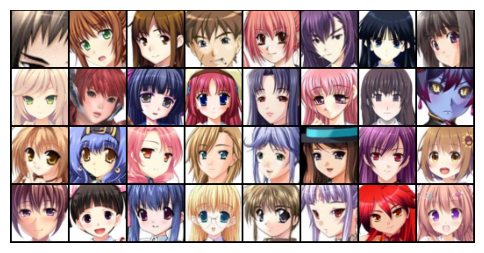

Batch shape: torch.Size([64, 3, 64, 64])


In [ ]:
class AnimeFaceDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = Path(root)
        self.files = sorted(self.root.glob("*.jpg"))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

DATA_PATH = "data/anime_faces"
IMAGE_SIZE = 64
BATCH_SIZE = 64

tfm = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # [-1, 1]
])

dataset = AnimeFaceDataset(DATA_PATH, transform=tfm)

loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)


x = next(iter(loader))  # [B, 3, 64, 64]

grid = make_grid(x[:32], nrow=8, normalize=True)

plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()

print("Batch shape:", x.shape)


<p class="task" id="2"></p>

2\. Реализуйте архитектуру `DCGAN` и обучите модель. Подберите гиперпараметры таким образом, чтобы получаемые изображения стали достаточного качественными (четкими и без существенных дефектов). Во время обучения сохраняйте примеры генерации изображений из случайного шума и сравните, как менялось качество получаемых изображений в процессе обучения.

- [ ] Проверено на семинаре


In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")

# --- гиперпараметры (стартовые, обычно дают норм качество на 64x64) ---
Z_DIM = 128
G_FEAT = 64
D_FEAT = 64

BATCH_SIZE = 64
EPOCHS = 10

LR = 2e-4
BETAS = (0.5, 0.999)

OUT_DIR = Path("dcgan_samples")
OUT_DIR.mkdir(parents=True, exist_ok=True)

torch.manual_seed(42)
fixed_noise = torch.randn(64, Z_DIM, 1, 1, device=device)


def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if getattr(m, "bias", None) is not None and m.bias is not None:
            nn.init.constant_(m.bias.data, 0)


class Generator(nn.Module):
    # z: [B, Z, 1, 1] -> img: [B, 3, 64, 64]
    def __init__(self, z_dim=128, img_ch=3, feat=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, feat * 8, 4, 1, 0, bias=False),  # 4x4
            nn.BatchNorm2d(feat * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(feat * 8, feat * 4, 4, 2, 1, bias=False),  # 8x8
            nn.BatchNorm2d(feat * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(feat * 4, feat * 2, 4, 2, 1, bias=False),  # 16x16
            nn.BatchNorm2d(feat * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feat * 2, feat, 4, 2, 1, bias=False),      # 32x32
            nn.BatchNorm2d(feat),
            nn.ReLU(True),

            nn.ConvTranspose2d(feat, img_ch, 4, 2, 1, bias=False),        # 64x64
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)


class Discriminator(nn.Module):
    # img: [B, 3, 64, 64] -> logits: [B]
    def __init__(self, img_ch=3, feat=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_ch, feat, 4, 2, 1, bias=False),  # 32x32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feat, feat * 2, 4, 2, 1, bias=False),  # 16x16
            nn.BatchNorm2d(feat * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feat * 2, feat * 4, 4, 2, 1, bias=False),  # 8x8
            nn.BatchNorm2d(feat * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feat * 4, feat * 8, 4, 2, 1, bias=False),  # 4x4
            nn.BatchNorm2d(feat * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feat * 8, 1, 4, 1, 0, bias=False)  # 1x1
        )

    def forward(self, x):
        return self.net(x).view(-1)


G = Generator(Z_DIM, img_ch=3, feat=G_FEAT).to(device)
D = Discriminator(img_ch=3, feat=D_FEAT).to(device)
G.apply(weights_init)
D.apply(weights_init)

criterion = nn.BCEWithLogitsLoss()

opt_G = optim.Adam(G.parameters(), lr=LR, betas=BETAS)
opt_D = optim.Adam(D.parameters(), lr=LR, betas=BETAS)


@torch.no_grad()
def save_samples(epoch):
    G.eval()
    fake = G(fixed_noise).cpu()
    grid = make_grid(fake, nrow=8, normalize=True)
    save_image(grid, OUT_DIR / f"epoch_{epoch:03d}.png")
    G.train()


for epoch in range(1, EPOCHS + 1):
    for real in loader:
        real = real.to(device)
        b = real.size(0)

        # --- train D ---
        noise = torch.randn(b, Z_DIM, 1, 1, device=device)
        fake = G(noise).detach()

        logits_real = D(real)
        logits_fake = D(fake)

        loss_D = criterion(logits_real, torch.ones_like(logits_real)) + \
                 criterion(logits_fake, torch.zeros_like(logits_fake))

        opt_D.zero_grad(set_to_none=True)
        loss_D.backward()
        opt_D.step()

        # --- train G ---
        noise = torch.randn(b, Z_DIM, 1, 1, device=device)
        fake = G(noise)
        logits_fake = D(fake)

        loss_G = criterion(logits_fake, torch.ones_like(logits_fake))

        opt_G.zero_grad(set_to_none=True)
        loss_G.backward()
        opt_G.step()

    print(f"Epoch {epoch:03d}/{EPOCHS} | D: {loss_D.item():.4f} | G: {loss_G.item():.4f}")
    save_samples(epoch)


Epoch 001/10 | D: 0.5119 | G: 3.7498
Epoch 002/10 | D: 0.7000 | G: 6.1858
Epoch 003/10 | D: 0.3391 | G: 5.8374
Epoch 004/10 | D: 0.2881 | G: 4.3097
Epoch 005/10 | D: 0.2459 | G: 2.5897
Epoch 006/10 | D: 0.0946 | G: 4.3916
Epoch 007/10 | D: 0.0674 | G: 7.0120
Epoch 008/10 | D: 1.8250 | G: 0.9199
Epoch 009/10 | D: 0.2098 | G: 5.6137
Epoch 010/10 | D: 0.0092 | G: 6.1076


<p class="task" id="3"></p>

3\. Создайте наборы данных на основе архива `summer2winter_yosemite.zip`. Используя преобразования `torchvision`, приведите изображения к одному размеру и нормализуйте их. Выведите на экран несколько примеров изображений, расположив изображения из одной пары рядом по горизонтали.

- [ ] Проверено на семинаре

In [7]:
from pathlib import Path
from PIL import Image
import zipfile

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# --- 1) распаковка (если уже распаковано — просто пропустит) ---
ZIP_PATH = Path("summer2winter_yosemite.zip")
OUT_ROOT = Path("summer2winter_yosemite")

if ZIP_PATH.exists() and not OUT_ROOT.exists():
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(OUT_ROOT.parent)  # распакует в data/

# после распаковки часто получается data/summer2winter_yosemite/...
# или data/summer2winter_yosemite/...
# сделаем авто-поиск папки с trainA/trainB
def find_cyclegan_root(base: Path) -> Path:
    # ищем директорию, где есть trainA и trainB
    candidates = [base] + [p for p in base.glob("**/") if p.is_dir()]
    for p in candidates:
        if (p / "train/A").exists() and (p / "train/B").exists():
            return p

DATA_ROOT = find_cyclegan_root(OUT_ROOT if OUT_ROOT.exists() else ZIP_PATH.parent)

print("DATA_ROOT:", DATA_ROOT)
print("Folders:", [p.name for p in DATA_ROOT.iterdir() if p.is_dir()])


DATA_ROOT: summer2winter_yosemite
Folders: ['train', 'test']


In [6]:
!ls -lh summer2winter_yosemite.zip
!file summer2winter_yosemite.zip
!unzip -t summer2winter_yosemite.zip | head -n 40


-rw-r--r-- 1 root root 127M Dec 21 01:50 summer2winter_yosemite.zip
summer2winter_yosemite.zip: Zip archive data, at least v2.0 to extract, compression method=store
Archive:  summer2winter_yosemite.zip
summer2winter_yosemite/test/A/2010-09-07 122320.jpg:  mismatching "local" filename (summer2winter_yosemite/test/A/2010-09-07 12яА║23яА║20.jpg),
         continuing with "central" filename version
    testing: summer2winter_yosemite/   OK
    testing: summer2winter_yosemite/test/   OK
    testing: summer2winter_yosemite/test/A/   OK
summer2winter_yosemite/test/A/2010-09-07 122320.jpg:  mismatching "local" filename (summer2winter_yosemite/test/A/2010-09-07 12яА║23яА║20.jpg),
         continuing with "central" filename version
summer2winter_yosemite/test/A/2010-10-05 134511.jpg:  mismatching "local" filename (summer2winter_yosemite/test/A/2010-10-05 13яА║45яА║11.jpg),
         continuing with "central" filename version
    testing: summer2winter_yosemite/test/A/2010-09-07 122320.jpg

In [8]:
class UnpairedImageDataset(Dataset):
    """
    CycleGAN обучается на НЕпарных доменах.
    Возвращаем (imgA, imgB), выбирая B случайно, чтобы не подразумевать истинные пары.
    """
    def __init__(self, rootA, rootB, transform=None, exts=(".jpg", ".jpeg", ".png")):
        self.rootA = Path(rootA)
        self.rootB = Path(rootB)
        self.transform = transform

        self.filesA = []
        self.filesB = []
        for e in exts:
            self.filesA += list(self.rootA.glob(f"*{e}"))
            self.filesB += list(self.rootB.glob(f"*{e}"))
        self.filesA = sorted(self.filesA)
        self.filesB = sorted(self.filesB)

        if len(self.filesA) == 0 or len(self.filesB) == 0:
            raise FileNotFoundError("Проверь, что в trainA/trainB реально есть изображения.")

    def __len__(self):
        # берём максимум, чтобы обе стороны примерно одинаково “крутились”
        return max(len(self.filesA), len(self.filesB))

    def __getitem__(self, idx):
        # A идёт по кругу, B — случайный индекс (непара)
        pathA = self.filesA[idx % len(self.filesA)]
        idxB = torch.randint(0, len(self.filesB), (1,)).item()
        pathB = self.filesB[idxB]

        imgA = Image.open(pathA).convert("RGB")
        imgB = Image.open(pathB).convert("RGB")

        if self.transform:
            imgA = self.transform(imgA)
            imgB = self.transform(imgB)

        return imgA, imgB


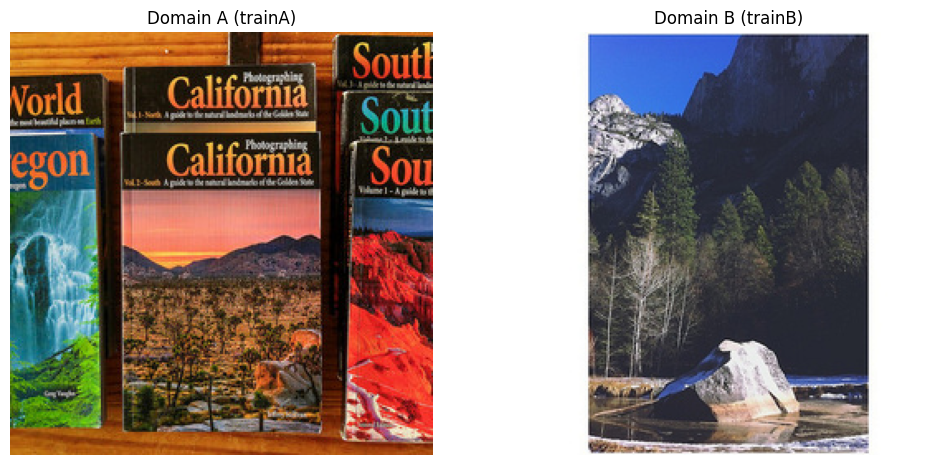

A batch: torch.Size([1, 3, 256, 256])  | B batch: torch.Size([1, 3, 256, 256])


In [9]:
# --- 2) transforms ---
# Для CycleGAN обычно используют 256x256 и Normalize -> [-1, 1]
IMG_SIZE = 256 # долго тянет иначе
BATCH_SIZE = 1

tfm = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

trainA = DATA_ROOT / "train/A"  # обычно: summer
trainB = DATA_ROOT / "train/B"  # обычно: winter

ds = UnpairedImageDataset(trainA, trainB, transform=tfm)

# важно для macOS/Jupyter
loader = DataLoader(
    ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

# --- 3) визуализация "пар" (на самом деле непарных) ---
A, B = next(iter(loader))  # A,B: [B,3,256,256]

gridA = make_grid(A, nrow=BATCH_SIZE, normalize=True)
gridB = make_grid(B, nrow=BATCH_SIZE, normalize=True)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Domain A (trainA)")
plt.imshow(gridA.permute(1, 2, 0))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Domain B (trainB)")
plt.imshow(gridB.permute(1, 2, 0))
plt.axis("off")

plt.show()

print("A batch:", A.shape, " | B batch:", B.shape)


<p class="task" id="4"></p>

4\. Реализуйте архитектуру `CycleGAN` и обучите модель. Подберите гиперпараметры таким образом, чтобы получаемые изображения стали достаточного качественными (четкими и без существенных дефектов). Во время обучения сохраняйте примеры преобразования (в обе стороны) и  сравните, как менялось качество получаемых изображений в процессе обучения.

- [ ] Проверено на семинаре

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image, make_grid
from pathlib import Path

device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")

OUT_DIR = Path("cyclegan_samples")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- гиперпараметры (стандарт для CycleGAN 256x256) ---
EPOCHS = 10
LR = 2e-4
BETAS = (0.5, 0.999)

LAMBDA_CYCLE = 10.0
LAMBDA_ID = 5.0  # часто ставят 0.5*LAMBDA_CYCLE

torch.manual_seed(42)


In [11]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.InstanceNorm2d)):
        if getattr(m, "weight", None) is not None and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        if getattr(m, "bias", None) is not None and m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3, 1, 0, bias=False),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),

            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3, 1, 0, bias=False),
            nn.InstanceNorm2d(dim),
        )

    def forward(self, x):
        return x + self.block(x)

class ResnetGenerator(nn.Module):
    # 256x256: обычно 9 res-блоков
    def __init__(self, in_ch=3, out_ch=3, n_res=9, base=32):
        super().__init__()
        layers = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_ch, base, 7, 1, 0, bias=False),
            nn.InstanceNorm2d(base),
            nn.ReLU(True),
        ]

        # downsample: 256->128->64
        c = base
        for _ in range(2):
            layers += [
                nn.Conv2d(c, c*2, 3, 2, 1, bias=False),
                nn.InstanceNorm2d(c*2),
                nn.ReLU(True),
            ]
            c *= 2

        # res blocks
        for _ in range(n_res):
            layers += [ResnetBlock(c)]

        # upsample: 64->128->256
        for _ in range(2):
            layers += [
                nn.ConvTranspose2d(c, c//2, 3, 2, 1, output_padding=1, bias=False),
                nn.InstanceNorm2d(c//2),
                nn.ReLU(True),
            ]
            c //= 2

        layers += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(c, out_ch, 7, 1, 0),
            nn.Tanh()
        ]

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class PatchDiscriminator(nn.Module):
    # PatchGAN: выдаёт карту "реально/фейк" (патчи)
    def __init__(self, in_ch=3, base=32):
        super().__init__()
        def block(in_c, out_c, norm=True):
            layers = [nn.Conv2d(in_c, out_c, 4, 2, 1)]
            if norm:
                layers += [nn.InstanceNorm2d(out_c)]
            layers += [nn.LeakyReLU(0.2, inplace=True)]
            return layers

        layers = []
        layers += block(in_ch, base, norm=False)      # 256->128
        layers += block(base, base*2)                 # 128->64
        layers += block(base*2, base*4)               # 64->32
        layers += block(base*4, base*8)               # 32->16
        layers += [nn.Conv2d(base*8, 1, 4, 1, 1)]     # 16->15 (примерно)

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)  # [B,1,H',W']


In [12]:
import random

class ReplayBuffer:
    # пул фейковых изображений для стабилизации D
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, batch):
        out = []
        for img in batch:
            img = img.detach().unsqueeze(0)
            if len(self.data) < self.max_size:
                self.data.append(img)
                out.append(img)
            else:
                if random.random() > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    out.append(self.data[i].clone())
                    self.data[i] = img
                else:
                    out.append(img)
        return torch.cat(out, dim=0)


In [13]:
# --- модели ---
G_AB = ResnetGenerator().to(device)  # A -> B
G_BA = ResnetGenerator().to(device)  # B -> A
D_A = PatchDiscriminator().to(device)
D_B = PatchDiscriminator().to(device)

for m in [G_AB, G_BA, D_A, D_B]:
    m.apply(weights_init)

# --- лоссы ---
# LSGAN (как в оригинальном CycleGAN): MSE на logits-карте
gan_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()
id_loss = nn.L1Loss()

# --- оптимизаторы ---
opt_G = optim.AdamW(list(G_AB.parameters()) + list(G_BA.parameters()), lr=LR, betas=BETAS)
opt_D_A = optim.AdamW(D_A.parameters(), lr=LR, betas=BETAS)
opt_D_B = optim.AdamW(D_B.parameters(), lr=LR, betas=BETAS)

fake_A_pool = ReplayBuffer(50)
fake_B_pool = ReplayBuffer(50)

def ones_like(x):  # для PatchGAN-выхода
    return torch.ones_like(x, device=x.device)

def zeros_like(x):
    return torch.zeros_like(x, device=x.device)

@torch.no_grad()
def save_cycle_samples(epoch, real_A, real_B):
    G_AB.eval(); G_BA.eval()
    fake_B = G_AB(real_A)
    fake_A = G_BA(real_B)

    rec_A = G_BA(fake_B)
    rec_B = G_AB(fake_A)

    # 1 строка: real_A | fake_B | rec_A
    row1 = torch.cat([real_A[:4].cpu(), fake_B[:4].cpu(), rec_A[:4].cpu()], dim=0)
    grid1 = make_grid(row1, nrow=4, normalize=True)
    save_image(grid1, OUT_DIR / f"epoch_{epoch:03d}_A2B.png")

    # 2 строка: real_B | fake_A | rec_B
    row2 = torch.cat([real_B[:4].cpu(), fake_A[:4].cpu(), rec_B[:4].cpu()], dim=0)
    grid2 = make_grid(row2, nrow=4, normalize=True)
    save_image(grid2, OUT_DIR / f"epoch_{epoch:03d}_B2A.png")

    G_AB.train(); G_BA.train()


In [14]:
# ВАЖНО: loader должен быть из №3 и возвращать (A, B) в [-1,1]
for epoch in range(1, EPOCHS + 1):
    for real_A, real_B in loader:
        real_A = real_A.to(device)
        real_B = real_B.to(device)

        # ======================
        # 1) Train Generators
        # ======================
        opt_G.zero_grad(set_to_none=True)

        # identity: G_AB(B) ≈ B, G_BA(A) ≈ A (сохраняет цвета/тон)
        same_B = G_AB(real_B)
        same_A = G_BA(real_A)
        loss_id = id_loss(same_B, real_B) + id_loss(same_A, real_A)

        # GAN: хотим, чтобы D_B(fake_B)=1 и D_A(fake_A)=1
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)
        loss_gan = gan_loss(D_B(fake_B), ones_like(D_B(fake_B))) + \
                   gan_loss(D_A(fake_A), ones_like(D_A(fake_A)))

        # cycle: A -> B -> A и B -> A -> B
        rec_A = G_BA(fake_B)
        rec_B = G_AB(fake_A)
        loss_cycle = cycle_loss(rec_A, real_A) + cycle_loss(rec_B, real_B)

        loss_G = loss_gan + LAMBDA_CYCLE * loss_cycle + LAMBDA_ID * loss_id
        loss_G.backward()
        opt_G.step()

        # ======================
        # 2) Train Discriminator A
        # ======================
        opt_D_A.zero_grad(set_to_none=True)

        pred_real_A = D_A(real_A)
        loss_DA_real = gan_loss(pred_real_A, ones_like(pred_real_A))

        fake_A_buf = fake_A_pool.push_and_pop(fake_A)
        pred_fake_A = D_A(fake_A_buf)
        loss_DA_fake = gan_loss(pred_fake_A, zeros_like(pred_fake_A))

        loss_D_A = 0.5 * (loss_DA_real + loss_DA_fake)
        loss_D_A.backward()
        opt_D_A.step()

        # ======================
        # 3) Train Discriminator B
        # ======================
        opt_D_B.zero_grad(set_to_none=True)

        pred_real_B = D_B(real_B)
        loss_DB_real = gan_loss(pred_real_B, ones_like(pred_real_B))

        fake_B_buf = fake_B_pool.push_and_pop(fake_B)
        pred_fake_B = D_B(fake_B_buf)
        loss_DB_fake = gan_loss(pred_fake_B, zeros_like(pred_fake_B))

        loss_D_B = 0.5 * (loss_DB_real + loss_DB_fake)
        loss_D_B.backward()
        opt_D_B.step()

    print(f"Epoch {epoch:03d}/{EPOCHS} | G: {loss_G.item():.3f} "
          f"| D_A: {loss_D_A.item():.3f} | D_B: {loss_D_B.item():.3f}")

    # сохраняем примеры (фиксируем именно текущий batch — достаточно для отчёта)
    save_cycle_samples(epoch, real_A, real_B)


Epoch 001/10 | G: 6.668 | D_A: 0.163 | D_B: 0.194
Epoch 002/10 | G: 7.406 | D_A: 0.230 | D_B: 0.233
Epoch 003/10 | G: 7.771 | D_A: 0.178 | D_B: 0.099
Epoch 004/10 | G: 6.354 | D_A: 0.254 | D_B: 0.105
Epoch 005/10 | G: 5.703 | D_A: 0.155 | D_B: 0.403
Epoch 006/10 | G: 3.846 | D_A: 0.206 | D_B: 0.282
Epoch 007/10 | G: 8.257 | D_A: 0.206 | D_B: 0.058
Epoch 008/10 | G: 5.245 | D_A: 0.189 | D_B: 0.173
Epoch 009/10 | G: 4.772 | D_A: 0.546 | D_B: 0.223
Epoch 010/10 | G: 3.869 | D_A: 0.334 | D_B: 0.261


In [15]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

SAMPLES_DIR = Path("cyclegan_samples")

files = sorted(SAMPLES_DIR.glob("*.png"))
print("Saved files:", len(files))

for f in files:
    print(f.name)


Saved files: 20
epoch_001_A2B.png
epoch_001_B2A.png
epoch_002_A2B.png
epoch_002_B2A.png
epoch_003_A2B.png
epoch_003_B2A.png
epoch_004_A2B.png
epoch_004_B2A.png
epoch_005_A2B.png
epoch_005_B2A.png
epoch_006_A2B.png
epoch_006_B2A.png
epoch_007_A2B.png
epoch_007_B2A.png
epoch_008_A2B.png
epoch_008_B2A.png
epoch_009_A2B.png
epoch_009_B2A.png
epoch_010_A2B.png
epoch_010_B2A.png


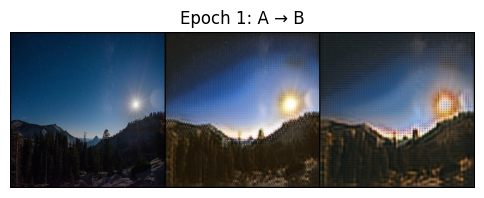

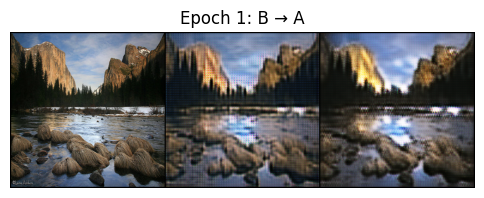

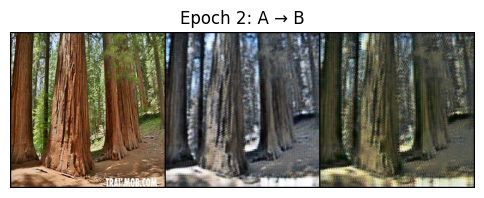

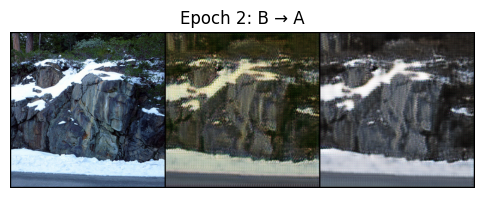

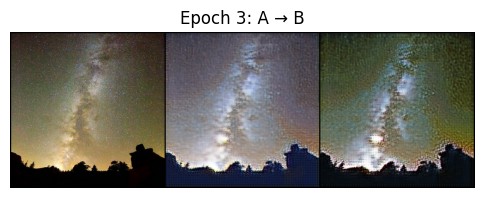

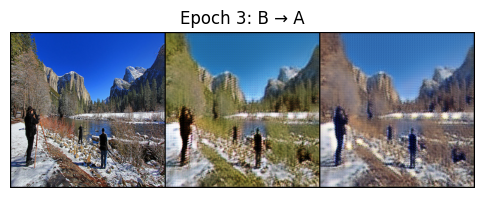

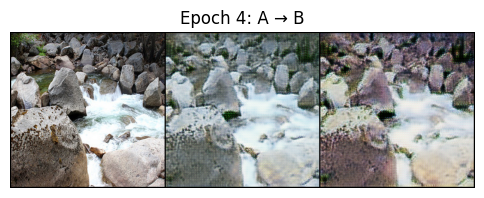

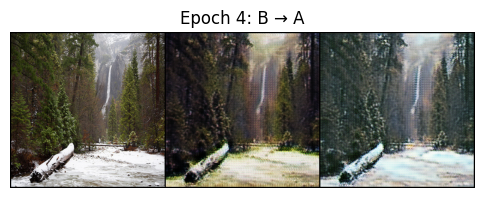

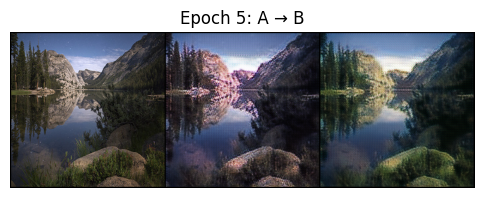

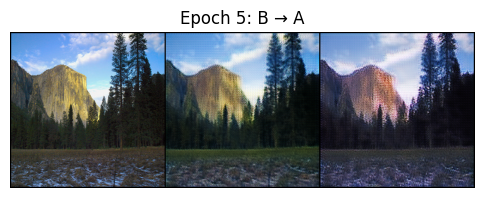

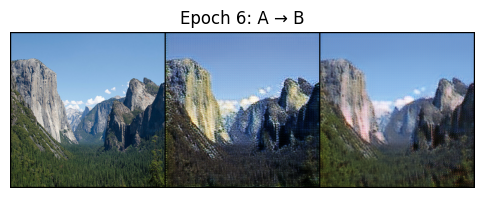

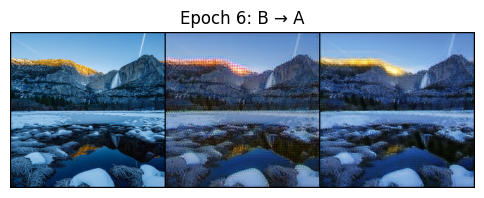

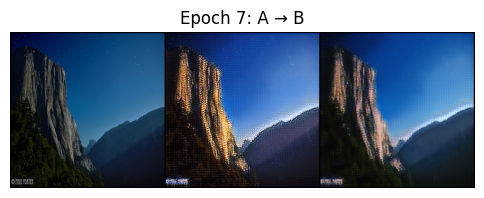

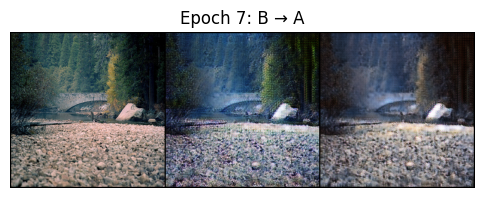

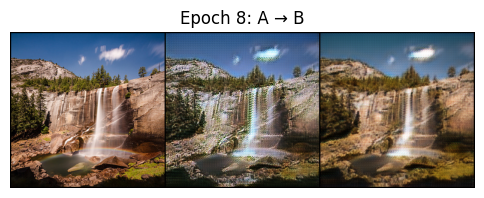

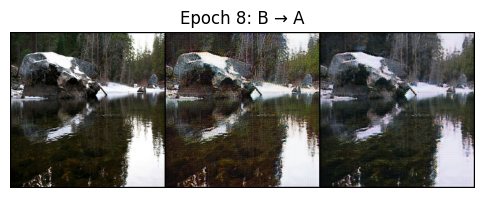

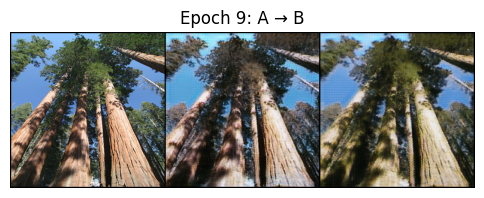

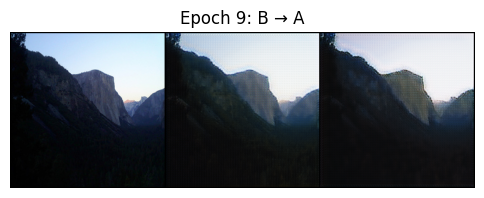

In [19]:
def show_image(path, title=None):
    img = Image.open(path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()
for i in range(1,10):
  show_image(SAMPLES_DIR / f"epoch_00{i}_A2B.png", f"Epoch {i}: A → B")
  show_image(SAMPLES_DIR / f"epoch_00{i}_B2A.png", f"Epoch {i}: B → A")

